# LocalCart scenario two: Static data analysis using Python and PixieDust
***

In this notebook, you'll first analyze customer demographics, such as, age, gender, income, and location. Then you'll combine that data with sales data to examine trends for product categories, transaction types, and product popularity. You'll load data from a previous notebook as well as from a public open data set, cleanse, shape, and enrich the data, and then visualize the data with the PixieDust library. Don't worry! PixieDust graphs don't require coding. By the end of the notebook, you'll understand how to combine data to gain insights about which customers you might target to increase sales.


<img src="https://raw.githubusercontent.com/ibm-watson-data-lab/localcart-at-index-conf/master/images/static_analysis_flow.png"></img>


This notebook runs on Python 2 with Spark 2.1, and PixieDust 1.1.7.

<a id="toc"></a>
## Table of contents

#### [Setup](#Setup)
[Load data into the notebook](#Load-data-into-the-notebook)
#### [Part 1. Explore customer demographics](#part1)
[Prepare the customer data set](#Prepare-the-customer-data-set)<br>
[Visualize customer demographics and locations](#Visualize-customer-demographics-and-locations)<br>
[Enrich demographic information with open data](#Enrich-demographic-information-with-open-data)<br>   
#### [Part 2. Explore sales transactions](#part2)
[Prepare the sales data set](#Prepare-the-sales-data-set)<br>
[Classify sales](#Classify-sales)<br>
[Analyze monthly sales](#Analyze-monthly-sales)<br>
[Analyze order values](#Analyze-order-values)<br>
[Analyze sales over time](#Analyze-sales-over-time)<br>
[Analyze sales by demographic](#Analyze-sales-by-demographic)<br>
[Analyze abandoned transactions](#Analyze-abandoned-transactions)
#### [Summary and next steps](#summary)

## Setup
You need to import libraries and load the customer data into this notebook.

- Install the most current packages so we can take advantage of the latest features.

In [ ]:
# run this cell
# jinja2 version 2.10 is required
! pip install jinja2 --user --upgrade
# pixiedust version 1.1.7.1 is required
! pip install pixiedust --user --upgrade
! pip install bokeh --user --upgrade

> **If any package was updated restart the kernel and reload the browser page.**

Import the necessary libraries:

In [1]:
import pixiedust
import pyspark.sql.functions as func
import pyspark.sql.types as types
import re
import json
import os
import requests  

Pixiedust database opened successfully


### Load data into the notebook

The data file contains both the customer demographic data that you'll analyzed in Part 1, and the sales transaction data for Part 2.

In [2]:
raw_df = pixiedust.sampleData('https://raw.githubusercontent.com/ibm-watson-data-lab/localcart-at-index-conf/master/data/customers_orders1_opt.csv')

Downloaded 5662507 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/ibm-watson-data-lab/localcart-at-index-conf/master/data/customers_orders1_opt.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/ibm-watson-data-lab/localcart-at-index-conf/master/data/customers_orders1_opt.csv'


[Back to Table of Contents](#toc)
<a id="part1"></a>
# Part 1. Explore customer demographics 
In this part of the notebook, you'll prepare the customer data and then start learning about your customers by creating multiple charts and maps. 

## Prepare the customer data set
You'll create a new DataFrame with just the data you need and then cleanse and enrich the data.

Extract the columns that you want, remove duplicate customers, and add a column for aggregations:

In [3]:
display(raw_df)

CUSTNAME,GenderCode,ADDRESS1,CITY,STATE,COUNTRY_CODE,POSTAL_CODE,POSTAL_CODE_PLUS4,ADDRESS2,EMAIL_ADDRESS,PHONE_NUMBER,CREDITCARD_TYPE,LOCALITY,SALESMAN_ID,NATIONALITY,NATIONAL_ID,CREDITCARD_NUMBER,DRIVER_LICENSE,CUST_ID,ORDER_ID,ORDER_DATE,ORDER_TIME,FREIGHT_CHARGES,ORDER_SALESMAN,ORDER_POSTED_DATE,ORDER_SHIP_DATE,AGE,ORDER_VALUE,T_TYPE,PURCHASE_TOUCHPOINT,PURCHASE_STATUS,ORDER_TYPE,GENERATION,Baby Food,Diapers,Formula,Lotion,Baby wash,Wipes,Fresh Fruits,Fresh Vegetables,Beer,Wine,Club Soda,Sports Drink,Chips,Popcorn,Oatmeal,Medicines,Canned Foods,Cigarettes,Cheese,Cleaning Products,Condiments,Frozen Foods,Kitchen Items,Meat,Office Supplies,Personal Care,Pet Supplies,Sea Food,Spices
James Paine,Mr.,2846 Austin Avenue,Brownlow K.i.,SA,AU,5223,0,None,James.B.Paine@trashymail.com,(02) 6739 8771,Diners Club,None,NE304,ES,0512822Z,36569195164555,None,10455,8007,2016-02-06 00:00:00,2016-02-06 13:07:36.370000,15.22,NW379,2016-02-20 00:00:00,01/03/2016,NA,85.75,Complete,Phone,Occasional,MediumValue,Gen_Z,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0
Claudia Higgins,Mrs.,3239 Rosemont Avenue,Burnaby,BC,CA,V5G 4W7,0,None,Claudia.R.Higgins@pookmail.com,306-429-0675,VISA,None,SE271,IT,DMWTYI63S66E144E,4827203420336516,None,10483,2985,2016-02-29 00:00:00,2016-02-29 22:39:06.250000,28.55,SE331,2016-03-17 00:00:00,27/03/2016,51,23.99,Complete,Phone,Occasional,LowValue,Gen_X,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
Colin Rios,Mr.,808 Walnut Hill Drive,Greenville,NC,US,27834,0,None,Colin.M.Rios@trashymail.com,815-799-4214,American Express,None,WE415,FR,2.29E+14,341065162616497,None,11311,7835,2016-01-06 00:00:00,2016-01-06 18:23:54.564000,33.85,NW118,2016-01-26 00:00:00,07/02/2016,19,266.19,In-Progress,Phone,FirstTime,HighValue,Gen_Z,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1
Robin Green,Miss.,4367 Feathers Hooves Drive,Minneota,MN,US,56264,0,None,Robin.K.Green@dodgeit.com,607-684-4454,VISA,None,NW313,ES,X0341109L,4799890746491688,None,12023,3082,2016-03-08 00:00:00,2016-03-08 20:32:45.246000,13.82,NE304,2016-06-08 00:00:00,15/07/2016,age-64,9999999.0,Complete,Desktop,FirstTime,LowValue,Gen_Z,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Jeffery Ethier,Mr.,3962 Locust View Drive,San Germano Dei Berici,VI,IT,36040,0,None,Jeffery.L.Ethier@pookmail.com,0359 5787010,JCB,None,SC130,IT,FKXBZN73A04D423G,3528561890357559,None,12787,3332,2016-02-09 00:00:00,2016-02-09 18:50:44.886000,16.25,RP253,2016-02-28 00:00:00,10/03/2016,53,41.31,Complete,Phone,Occasional,LowValue,Baby_Boomers,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Lottie Cook,Mrs.,3449 Pheasant Ridge Road,THURLEIGH,None,UK,MK44 8KM,0,None,Lottie.J.Cook@spambob.com,070 1438 4545,JCB,None,WE421,IT,PZWEEE49B58G694S,3528209941868030,None,13131,986,2016-03-16 17:47:25,2016-03-16 17:47:25.375000,14.61,NE175,2016-03-16 17:47:25,05/08/2016,72,226.59,Complete,Desktop,Frequent,HighValue,Baby_Boomers,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
Catherine Jones,Mrs.,3832 Overlook Drive,Trecate,NO,IT,28069,0,None,Catherine.P.Jones@dodgeit.com,0330 8404841,Discover,None,SE139,U.S.,469490001,6011831317045310,None,13195,8335,2016-03-16 17:47:25,2016-03-16 17:47:25.375000,19.81,SW412,2016-03-16 17:47:25,05/08/2016,20,73.25,Complete,Phone,Occasional,MediumValue,Gen_Z,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
Amy Langan,Mrs.,2033 Eastland Avenue,Albuquerque,NM,US,87107,0,None,Amy.B.Langan@trashymail.com,305-827-8912,American Express,None,WE352,U.S.,22867951,342992658690097,None,10048,3979,2016-11-12 00:00:00,2016-11-12 17:43:54.564000,22.5,NW181,2016-11-30 00:00:00,12/12/2016,33,47.94,Complete,Phone,Occasional,LowValue,Gen_Y,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
Shirley Mccormick,Mrs.,1214 Irish Lane,Big Canyon,TX,US,79848,0,None,Shirley.W.Mccormick@trashymail.com,770-364-1002,JCB,None,NC361,ES,4302408M,3528650100945780,None,10324,1457,2016-04-29 00:00:00,2016-04-29 20:59:06.250000,23.78,WE34

In [4]:
# Extract the customer information from the data set
# CUSTNAME: string, GenderCode: string, ADDRESS1: string, CITY: string, STATE: string, COUNTRY_CODE: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, ADDRESS2: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, CREDITCARD_TYPE: string, LOCALITY: string, SALESMAN_ID: string, NATIONALITY: string, NATIONAL_ID: string, CREDITCARD_NUMBER: bigint, DRIVER_LICENSE: string, CUST_ID: int,
customer_df = raw_df.select("CUST_ID", 
                            "CUSTNAME", 
                            "ADDRESS1", 
                            "ADDRESS2", 
                            "CITY", 
                            "POSTAL_CODE", 
                            "POSTAL_CODE_PLUS4", 
                            "STATE", 
                            "COUNTRY_CODE", 
                            "EMAIL_ADDRESS", 
                            "PHONE_NUMBER",
                            "AGE",
                            "GenderCode",
                            "GENERATION",
                            "NATIONALITY", 
                            "NATIONAL_ID", 
                            "DRIVER_LICENSE").dropDuplicates()

# append a column to the DataFrame for aggregations
customer_df = customer_df.withColumn("count", func.lit(1))
customer_df

DataFrame[CUST_ID: int, CUSTNAME: string, ADDRESS1: string, ADDRESS2: string, CITY: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, STATE: string, COUNTRY_CODE: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, AGE: string, GenderCode: string, GENERATION: string, NATIONALITY: string, NATIONAL_ID: string, DRIVER_LICENSE: string, count: int]

Notice that the data type of the AGE column is currently a string. Convert the AGE column to a numeric data type so you can run calculations on customer age.

In [5]:
# ---------------------------------------
# Cleanse age (enforce numeric data type) 
# ---------------------------------------

def getNumericVal(col):
    """
    input: pyspark.sql.types.Column
    output: the numeric value represented by col or None
    """
    try:
      return int(col)
    except ValueError:
      # age-33
      match = re.match('^age\-(\d+)$', col)
      if match:
        try:
          return int(match.group(1))
        except ValueError:    
          return None
      return None  

toNumericValUDF = func.udf(lambda c: getNumericVal(c), types.IntegerType())
customer_df = customer_df.withColumn("AGE", toNumericValUDF(customer_df["AGE"]))

The GenderCode column contains salutations instead of gender values. Derive the gender information for each customer based on the salutation and rename the GenderCode column to GENDER.

In [6]:
# ------------------------------
# Derive gender from salutation
# ------------------------------
def deriveGender(col):
    """ input: pyspark.sql.types.Column
        output: "male", "female" or "unknown"
    """    
    if col in ['Mr.', 'Master.']:
        return 'male'
    elif col in ['Mrs.', 'Miss.']:
        return 'female'
    else:
        return 'unknown';
    
deriveGenderUDF = func.udf(lambda c: deriveGender(c), types.StringType())
customer_df = customer_df.withColumn("GENDER", deriveGenderUDF(customer_df["GenderCode"]))
customer_df.cache()

DataFrame[CUST_ID: int, CUSTNAME: string, ADDRESS1: string, ADDRESS2: string, CITY: string, POSTAL_CODE: string, POSTAL_CODE_PLUS4: int, STATE: string, COUNTRY_CODE: string, EMAIL_ADDRESS: string, PHONE_NUMBER: string, AGE: int, GenderCode: string, GENERATION: string, NATIONALITY: string, NATIONAL_ID: string, DRIVER_LICENSE: string, count: int, GENDER: string]

## Explore the customer data set

You can quickly explore data sets using PixieDust's data set explorer. Invoke the `display()` command and click the table icon to review the schema and preview the data. Customize the options to display only a subset of the fields or rows or apply a filter (by clicking the funnel icon).

In [7]:
display(customer_df)

[Back to Table of Contents](#toc)
## Visualize customer demographics and locations

Now you're ready explore the customer base. Using simple charts, you can quickly see these characteristics:
 * Customer demographics (gender and age)
 * Customer locations (city, state, and country)

You'll create charts with the PixieDust library:

 - [View customers by gender in a pie chart](#View-customers-by-gender-in-a-pie-chart)
 - [View customers by generation in a bar chart](#View-customers-by-generation-in-a-bar-chart)
 - [View customers by age in a histogram chart](#View-customers-by-age-in-a-histogram-chart)
 - [View specific information with a filter function](#View-specific-information-with-a-filter-function)
 - [View customer density by location with a map](#View-customer-density-by-location-with-a-map)

### View customers by gender in a pie chart

Run the `display()` command and then configure the graph to show the percentages of male and female customers:

1. Run the next cell. The PixieDust interactive widget appears.  
1. Click the chart button and choose **Pie Chart**. The chart options tool appears.
1. In the chart options tool, drag `count` into the **Values** box. 
1. Move `GENDER` into the **Keys** box. 
1. In the **Aggregation** field, choose **COUNT**. 
1. Click **OK**. The pie chart appears.

If you want to make further changes, click **Options** to return to the chart options tool.


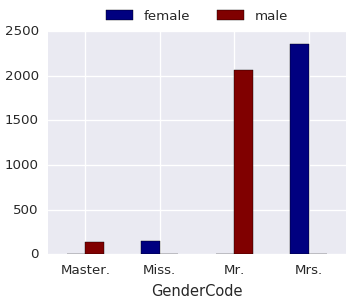

In [8]:
display(customer_df)

[Back to Table of Contents](#toc)
### View customers by generation in a bar chart
Look at how many customers you have per "generation."

Run the next cell and configure the graph: 
1. Choose **Bar Chart** as the chart type.
2. Put `GENERATION` into the **Keys** box.
3. Put `count` into the **Values** box.
4. Set aggregation to COUNT.


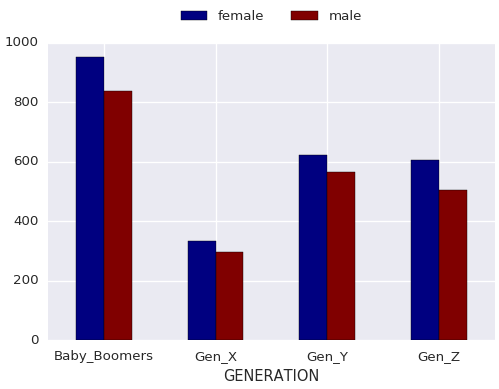

In [9]:
display(customer_df)

You can use clustering to group customers, for example by geographic location. To group generations by country, select `COUNTRY_CODE` from the **Cluster by** list. 

[Back to Table of Contents](#toc)
### View customers by age in a histogram chart
A generation is a broad age range. You can look at a smaller age range with a histogram chart. A histogram is like a bar chart except each bar represents a range of numbers, called a bin. You can customize the size of the age range by adjusting the bin size. The more bins you specify, the smaller the age range.

Run the next cell and configure the graph:
1. Choose **Histogram** as the chart type.
2. Put `AGE` into the **Values** box and click **OK**.
3. Use the **Bin count** slider to specify the number of the bins. Try starting with 40.

In [10]:
display(customer_df)

[Back to Table of Contents](#toc)
### View specific information with a filter function

You can filter records to restrict analysis by using the `filter()` function.

If you want to view the age distribution for a specific generation, uncomment the desired filter condition and run the next cell:

In [12]:
# Data subsetting: display age distribution for a specific generation
# (Chart type: histogram, Chart Options > Values: AGE)
# to change the filter condition remove the # sign 
#condition = "GENERATION = 'Baby_Boomers'"
condition = "GENERATION = 'Gen_X'"
#condition = "GENERATION = 'Gen_Y'"
#condition = "GENERATION = 'Gen_Z'"
display(customer_df.filter(condition))


PixieDust supports basic filtering to make it easy to analyse data subsets. For example, to view the age distribution for a specific gender configure the chart as follows:

  1. Choose `Histogram` as the chart type.
  2. Put `AGE` into the **Values** box and click OK.
  3. Click the filter button (looking like a funnel), and choose **GENDER** as field and `female` as value.


In [13]:
display(customer_df)

You can also filter by location. For example, the following command creates a new DataFrame that filters for customers from the USA:

In [14]:
condition = "COUNTRY_CODE = 'US'"
us_customer_df = customer_df.filter(condition)

You can pivot your analysis perspective based on aspects that are of interest to you by choosing different keys and clusters.

Create a bar chart and cluster the data.

Run the next cell and configure the graph:
1. Choose **Bar chart** as the chart type.
2. Put `COUNTRY_CODE` into the **Keys** box.
3. Put `count` in the **Values** box.
4. Set Aggregation to **COUNT**.
5. Click **OK**. The chart displays the number of US customers.
6. From the **Cluster By** list, choose **GENDER**. The chart shows the number of customers by gender.


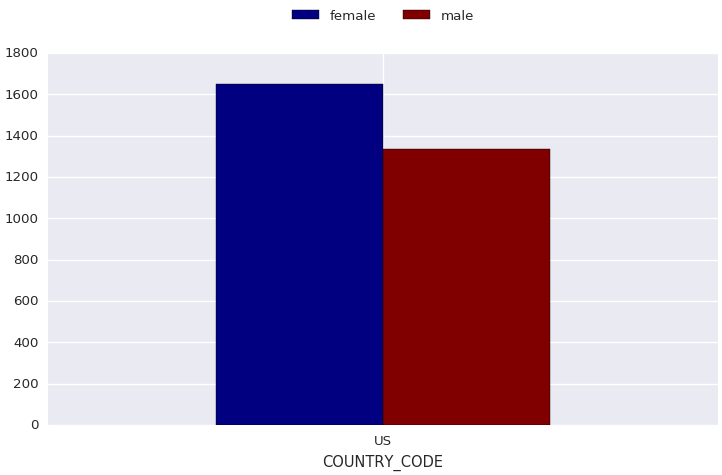

In [15]:
display(us_customer_df)

Now try to cluster the customers by state.

A bar chart isn't the best way to show geographic location!

[Back to Table of Contents](#toc)
### View customer density by location with a map
Maps are a much better way to view location data than other chart types. 

Visualize customer density by US state with a map.

Run the next cell and configure the graph:
1. Choose **Map** as the chart type.
2. Put `STATE` into the **Keys** box.
3. Put `count` in the **Values** box.
4. Set Aggregation to **COUNT**.
5. Click **OK**. The map displays the number of US customers.
6. From the **Renderer** list, choose **brunel**.
   > PixieDust supports three map renderers: brunel, [mapbox](https://www.mapbox.com/) and Google. Note that the Mapbox renderer and the Google renderer require an API key or access token and supported features vary by renderer.

In [16]:
display(us_customer_df)

You can explore more about customers in each state by changing the aggregation method. 

Look at customer age ranges (avg, minimum, and maximum) by state.

Run the next cell and configure the graph:
1. Choose **Map** as the chart type.
2. Put `STATE` into the **Keys** box.
3. Put `AGE` in the **Values** box.
4. Set Aggregation to **AVG**, **MAX**, or **MIN**.
5. Click **OK**. The map displays.
6. From the **Renderer** list, choose **brunel**.

In [ ]:
display(us_customer_df)

[Back to Table of Contents](#toc)
## Enrich demographic information with open data
You can easily combine other sources of data with your existing data. There's a lot of publicly available open data sets that can be very helpful. For example, knowing the approximate income level of your customers might help you target your marketing campaigns.

Run the next cell to load [this data set](https://apsportal.ibm.com/exchange/public/entry/view/beb8c30a3f559e58716d983671b70337) from the United States Census Bureau into your notebook. The data set contains US household income statistics compiled at the zip code geography level.

In [18]:
# Load median income information for all US ZIP codes from a public source
income_df = pixiedust.sampleData('https://apsportal.ibm.com/exchange-api/v1/entries/beb8c30a3f559e58716d983671b70337/data?accessKey=1c0b5b6d465fefec1ab529fde04997af')

Downloaded 6007673 bytes
Creating pySpark DataFrame for 'https://apsportal.ibm.com/exchange-api/v1/entries/beb8c30a3f559e58716d983671b70337/data?accessKey=1c0b5b6d465fefec1ab529fde04997af'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://apsportal.ibm.com/exchange-api/v1/entries/beb8c30a3f559e58716d983671b70337/data?accessKey=1c0b5b6d465fefec1ab529fde04997af'


Now cleanse the income data set to remove the data that you don't need. Create a new DataFrame for this data:
 - The zip code, extracted from the GEOID column.
 - The column B19049e1, which contains the median household income for 2013.

In [19]:
# ------------------------------
# Helper: Extract ZIP code
# ------------------------------
def extractZIPCode(col):
    """ input: pyspark.sql.types.Column containing a geo code, like '86000US01001'
        output: ZIP code
    """
    m = re.match('^\d+US(\d\d\d\d\d)$',col)
    if m:
        return m.group(1)
    else:
        return None    
    
getZIPCodeUDF = func.udf(lambda c: extractZIPCode(c), types.StringType())
income_df = income_df.select('GEOID', 'B19049e1').withColumnRenamed('B19049e1', 'MEDIAN_INCOME_IN_ZIP').withColumn("ZIP", getZIPCodeUDF(income_df['GEOID']))
income_df

DataFrame[GEOID: string, MEDIAN_INCOME_IN_ZIP: int, ZIP: string]

Now perform a left outer join on the customer data set with the income data set, using the zip code as the join condition. For the complete syntax of joins, go to the <a href="https://spark.apache.org/docs/1.5.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame" target="_blank" rel="noopener noreferrer">pyspark DataFrame documentation</a> and scroll down to the `join` syntax. 

In [20]:
us_customer_df = us_customer_df.join(income_df, us_customer_df.POSTAL_CODE == income_df.ZIP, 'left_outer').drop('GEOID').drop('ZIP')

Now you can visualize the income distribution of your customers by zip code.
 Visualize income distribution for our customers.
Run the next cell and configure the graph:
1. Choose **Histogram** as the chart type.
2. Put `MEDIAN_INCOME_IN_ZIP` into the **Values** box and click **OK**.

In [ ]:
display(us_customer_df)

The majority of your customers live in zip codes where the median income is around 40,000 USD. 

[Back to Table of Contents](#toc)
<a id="part2"></a>
# Part 2. Explore sales transactions
In this part of the notebook, you'll analyze time-based sales transactions summaries.

You'll answer these questions about your sales:

- Who buys which products?
- How much money is left on the table in abandoned transactions?
- Which products are the best sellers?

## Prepare the sales data set
You'll create a new DataFrame with just the data you need and then cleanse and enrich the data.

Extract the columns that you want, remove duplicate customers, and add a column for aggregations:

In [22]:
# Extract sales information from raw data set
# 
sales_df = raw_df.select("CUST_ID", 
                         "CITY", 
                         "STATE", 
                         "COUNTRY_CODE", 
                         "GenderCode",
                         "GENERATION",
                         "AGE",
                         "CREDITCARD_TYPE",
                         "ORDER_ID",
                         "ORDER_TIME",
                         "FREIGHT_CHARGES",
                         "ORDER_SALESMAN",
                         "ORDER_POSTED_DATE",
                         "ORDER_SHIP_DATE",
                         "ORDER_VALUE",
                         "T_TYPE",
                         "PURCHASE_TOUCHPOINT",
                         "PURCHASE_STATUS",
                         "ORDER_TYPE",
                         "Baby Food",
                         "Diapers",
                         "Formula",
                         "Lotion", 
                         "Baby wash",
                         "Wipes",
                         "Fresh Fruits",
                         "Fresh Vegetables",
                         "Beer",
                         "Wine",
                         "Club Soda",
                         "Sports Drink",
                         "Chips",
                         "Popcorn",
                         "Oatmeal",
                         "Medicines",
                         "Canned Foods",
                         "Cigarettes",
                         "Cheese",
                         "Cleaning Products",
                         "Condiments",
                         "Frozen Foods",
                         "Kitchen Items",
                         "Meat",
                         "Office Supplies",
                         "Personal Care",
                         "Pet Supplies",
                         "Sea Food",
                         "Spices").dropDuplicates()

# add column containing the numeric value 1. it will be used to perform aggregations
sales_df = sales_df.withColumn("count", func.lit(1))

Format the data:
 - Convert age values to numbers instead of strings. 
 - Derive customer gender. 
 - Convert the date column to a string. 
 - Add columns for date processing.

In [23]:
# ---------------------------------------
# Cleanse age (enforce numeric data type) 
# ---------------------------------------

def getNumericVal(col):
    """
    input: pyspark.sql.types.Column
    output: the numeric value represented by col or None
    """
    try:
      return int(col)
    except ValueError:
      # age-33
      match = re.match('^age\-(\d+)$', col)
      if match:
        try:
          return int(match.group(1))
        except ValueError:    
          return None
      return None  

toNumericValUDF = func.udf(lambda c: getNumericVal(c), types.IntegerType())
sales_df = sales_df.withColumn("AGE", toNumericValUDF(sales_df["AGE"]))

# ------------------------------
# Derive gender from salutation
# ------------------------------
def deriveGender(col):
    """ input: pyspark.sql.types.Column
        output: "male", "female" or "unknown"
    """    
    if col in ['Mr.', 'Master.']:
        return 'male'
    elif col in ['Mrs.', 'Miss.']:
        return 'female'
    else:
        return 'unknown';
    
deriveGenderUDF = func.udf(lambda c: deriveGender(c), types.StringType())
sales_df = sales_df.withColumn("GENDER", deriveGenderUDF(sales_df["GenderCode"]))

# ------------------------------
# get date column as string
# ------------------------------
def getDateString(datetime_col, format_string):
    """ input: pyspark.sql.types.Column
        input: string a strftime format string (https://docs.python.org/2/library/time.html#time.strftime)
        output: a formatted date string
    """    
    if format_string is None:
        format_string = '%d/%m/%Y'
    return datetime_col.strftime(format_string)

# append columns to data set:
#  - add ORDER_S_DATE (string representation of the order date - to address a PixieDust limitation)
#  - add ORDER_DATE_YEAR (string representation of the order date year: YYYY)
#  - add ORDER_DATE_MONTH (string representation of the order date month: YYYY-MM)

getDateStringUDF = func.udf(lambda c: getDateString(c, None), types.StringType())
sales_df = sales_df.withColumn("ORDER_DATE_S", getDateStringUDF(sales_df["ORDER_TIME"]))

getYearStringUDF = func.udf(lambda c: getDateString(c,'%Y'), types.StringType())
sales_df = sales_df.withColumn("ORDER_DATE_YEAR", getYearStringUDF(sales_df["ORDER_TIME"]))

getMonthStringUDF = func.udf(lambda c: getDateString(c,'%Y-%m'), types.StringType())
sales_df = sales_df.withColumn("ORDER_DATE_MONTH", getMonthStringUDF(sales_df["ORDER_TIME"]))

# cache the DataFrame to speed up analysis
sales_df.cache()

DataFrame[CUST_ID: int, CITY: string, STATE: string, COUNTRY_CODE: string, GenderCode: string, GENERATION: string, AGE: int, CREDITCARD_TYPE: string, ORDER_ID: int, ORDER_TIME: timestamp, FREIGHT_CHARGES: double, ORDER_SALESMAN: string, ORDER_POSTED_DATE: timestamp, ORDER_SHIP_DATE: string, ORDER_VALUE: double, T_TYPE: string, PURCHASE_TOUCHPOINT: string, PURCHASE_STATUS: string, ORDER_TYPE: string, Baby Food: int, Diapers: int, Formula: int, Lotion: int, Baby wash: int, Wipes: int, Fresh Fruits: int, Fresh Vegetables: int, Beer: int, Wine: int, Club Soda: int, Sports Drink: int, Chips: int, Popcorn: int, Oatmeal: int, Medicines: int, Canned Foods: int, Cigarettes: int, Cheese: int, Cleaning Products: int, Condiments: int, Frozen Foods: int, Kitchen Items: int, Meat: int, Office Supplies: int, Personal Care: int, Pet Supplies: int, Sea Food: int, Spices: int, count: int, GENDER: string, ORDER_DATE_S: string, ORDER_DATE_YEAR: string, ORDER_DATE_MONTH: string]

[Back to Table of Contents](#toc)
## Classify sales

You're ready to look at sales transactions! 

Using simple charts, you'll explore location metrics, transaction status types, the number of sales per location, and the average sale per location:

 - [Show customers by country](#Show-customers-by-country)
 - [Show transaction status for the USA](#Show-transaction-status-for-the-USA)
 - [Show completed transactions](#Show-completed-transactions)
 - [Show average order value](#Show-average-order-value)

### Show customers by country
Show the number of customers for each country.

Run the next cell and configure the graph:
1. Choose **Bar chart** as the chart type.
2. Put `COUNTRY_CODE` into the **Values** box.
3. Put `count` in the **Values** box.
4. Set Aggregation to **SUM** and click **OK**. 


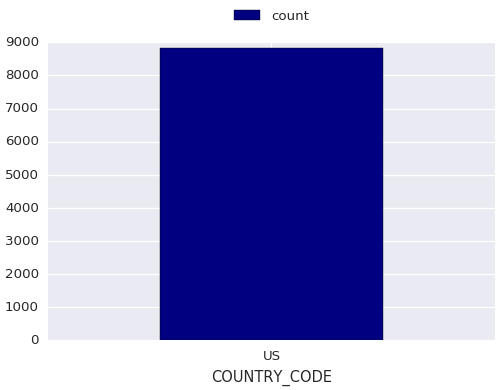

In [24]:
display(sales_df.groupBy("COUNTRY_CODE").count())

### Show transaction status for the USA
Take a look at how many of the transactions are complete compared to in-progress, cancelled, and abandoned.

First use a filter to restrict the geographical location to the USA.

In [25]:
# Apply optional filter 1: restrict geographic location to USA
sales_df = sales_df.filter("COUNTRY_CODE = 'US'")

Show percentages for the sales transaction status types for the USA.

Run the next cell and configure the graph:
1. Choose **Pie chart** as the chart type.
2. Put `T_TYPE` into the **Keys** box.
3. Put `count` in the **Values** box.
4. Set Aggregation to **SUM** and click **OK**. 


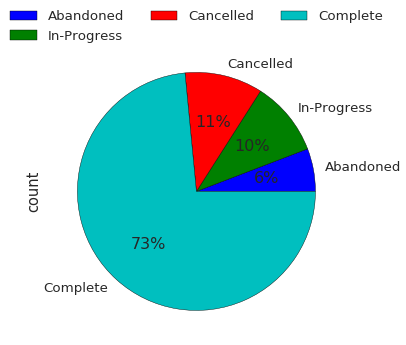

In [ ]:
display(sales_df.groupBy("T_TYPE").count())

### Show completed transactions

First use a filter to restrict the data to completed transactions.

In [27]:
# apply optional transaction status filter. Subsequent analysis is limited to these types of transactions
txn_sales_df = sales_df.filter("T_TYPE = 'Complete'")
#txn_sales_df = sales_df.filter("T_TYPE = 'Cancelled'")
#txn_sales_df = sales_df.filter("T_TYPE = 'Abandoned'")
#txn_sales_df = sales_df.filter("T_TYPE = 'In-Progress'")

Now show the number of completed transactions for each state in the USA, to answer the question, "How many sales were made in state X?"

Run the next cell and configure the graph:
1. Choose **Map** as the chart type.
2. Put `STATE` into the **Keys** box.
3. Put `count` in the **Values** box.
4. Set Aggregation to **COUNT**.
5. Click **OK**. The map displays.
6. From the **Renderer** list, choose **brunel**.

In [ ]:
display(txn_sales_df)

### Show average order value

Finally, calculate the average order value, for completed transactions, for each US state. Answer the question, "How much was the average transaction value in state X?"

Run the next cell and configure the graph:
1. Choose **Map** as the chart type.
2. Put `STATE` into the **Keys** box.
3. Put `ORDER_VALUE` in the **Values** box.
4. Set Aggregation to **AVG**.
5. Click **OK**. The map displays.
6. From the **Renderer** list, choose **brunel**.

In [ ]:
display(txn_sales_df)

[Back to Table of Contents](#toc)
## Analyze monthly sales
Now look at monthly sales for different demographics so you can answer these questions: How much are customers spending per month? Do men spend more than women? Do younger people splurge more than Baby Boomers?

Create a graph with monthly average sales by gender. 
 
Run the next cell and configure the graph:
1. Choose **Bar chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `ORDER_VALUE` in the **Values** box.
4. Set Aggregation to **SUM**.
5. Click **OK**. The chart displays.
6. From the **Renderer** list, choose **matplotlib**.
7. From the **Cluster By** list, choose **GENDER**.


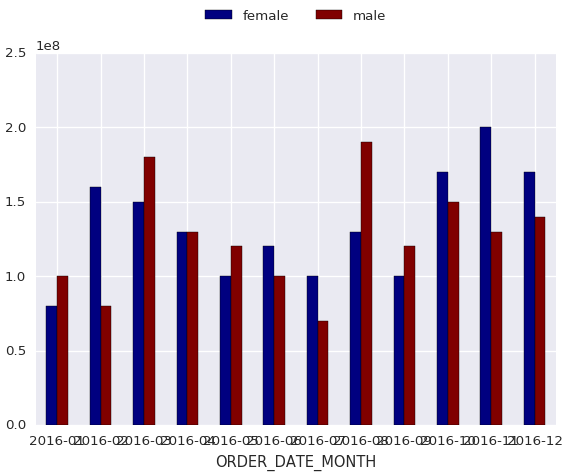

In [30]:
display(txn_sales_df)

Explore the data! Change the **Cluster By** value to `GENERATION` to see which age range spends the most. Remove the **Cluster By** value to see the total sales by month. Or you can change the value in the **Keys** box to ORDER_DATE_S to see daily sales or ORDER_DATE_YEAR to see yearly sales.

[Back to Table of Contents](#toc)
## Analyze order values
Look at the value of orders by demographic. Do older customers spend more money?

Filter the data to contain only completed transactions and to remove outlier order values:

In [31]:
# only inspect completed transactions
classify_df = sales_df.filter("T_TYPE = 'Complete'")
# test data set contains synthetic outliers. remove them
classify_df = classify_df.filter("ORDER_VALUE < 9999999")

Correlate the shopping basket value with age and gender. 

Run the next cell and configure the graph:
1. Choose **Scatter Plot** as the chart type.
2. Put `AGE` into the **Keys** box
3. Put `ORDER_VALUE` in the **Values** box.
4. Click **OK**. The chart displays.


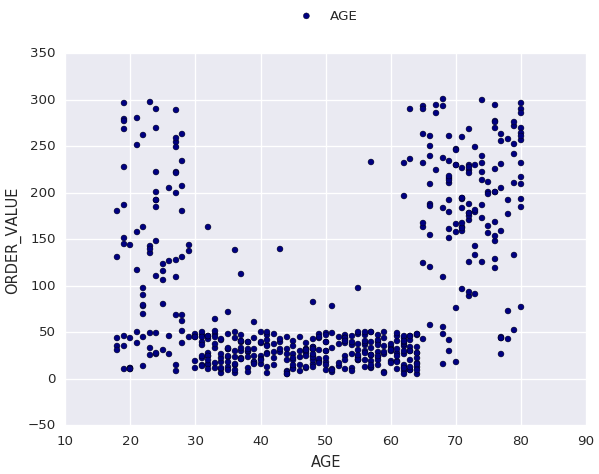

In [32]:
display(classify_df)

It looks like older customers tend to place orders with higher values.

[Back to Table of Contents](#toc)

## Analyze sales over time
Analyze your sales for trends over time. Which products are selling well in which month? Compare sales numbers for multiple product categories and identify seasonal trends.

Create a `category_columns` DataFrame so that you can group products by category:

In [33]:
# identify metadata columns in this data set
metadata_columns = [
                    'CUST_ID', 
                    'CITY', 
                    'count',
                    'STATE', 
                    'COUNTRY_CODE', 
                    'GenderCode', 
                    'GENDER',
                    'GENERATION',
                    'AGE',
                    'CREDITCARD_TYPE',
                    'ORDER_DATE_S',
                    'ORDER_DATE_YEAR',
                    'ORDER_DATE_MONTH',
                    'ORDER_ID',
                    'ORDER_TIME',
                    'FREIGHT_CHARGES',
                    'ORDER_SALESMAN',
                    'ORDER_POSTED_DATE',
                    'ORDER_SHIP_DATE',
                    'ORDER_VALUE',
                    'T_TYPE',
                    'PURCHASE_TOUCHPOINT',
                    'PURCHASE_STATUS',
                    'ORDER_TYPE',
                    'GENERATION'
                    ]

# identify item category columns
category_columns = []
for data_column in sales_df.columns:
    if data_column not in metadata_columns:
        category_columns.append(data_column)

Create a DataFrame that contains monthly sales totals by product category:

In [34]:
exprs = {x: "sum" for x in category_columns}
category_count_df = sales_df.groupBy("ORDER_DATE_MONTH").agg(exprs).alias("col")

Compare product categories for each month.

Run the next cell and configure the graph:
1. Choose **Bar Chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `sum(Fresh Vegetables)`, `sum(Fresh Fruits)`, and `sum(Sea Food)` in the **Values** box.
4. Set the Aggregation to **SUM**. 
4. Click **OK**. The chart displays.
5. From the **Type** list, choose **grouped**.


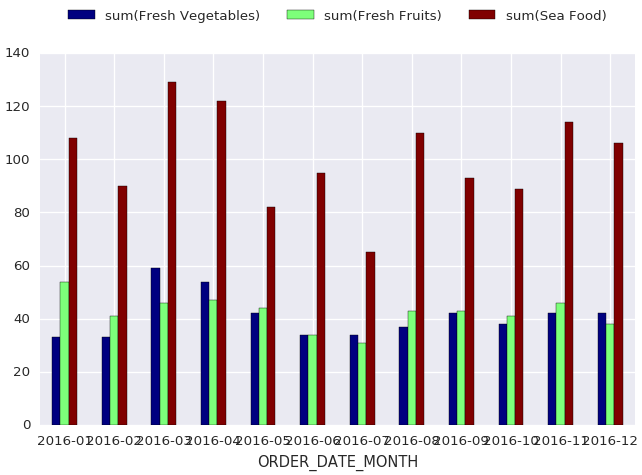

In [ ]:
display(category_count_df)

Customers spend a lot more money on seafood than fresh vegetables or fruit. Change the categories to compare products. Try changing the **Type** to **stacked** or **subplots** to see how you can configure your graph.

[Back to Table of Contents](#toc)

## Analyze sales by demographic
You can find out which demographic group purchases items in a specific product category. 

Find out whether women or men purchase more fresh vegetables.

Run the next cell and configure the graph:
1. Choose **Bar Chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `Fresh Vegetables` in the **Values** box.
4. Set the Aggregation to **COUNT**. 
5. Click **OK**. The chart displays.
6. From the **Cluster By** list, choose **GENDER**.
7. From the **Type** list, choose **grouped**.


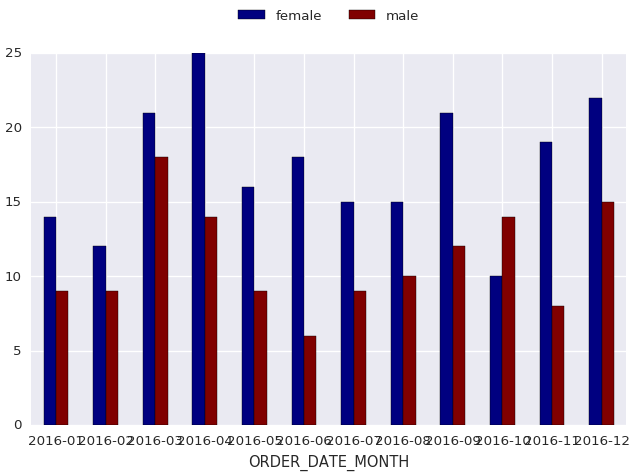

In [36]:
fresh_veggies_df = classify_df.filter(classify_df["Fresh Vegetables"] > 0)
display(fresh_veggies_df)

Women buy more fresh vegetables than men do. Now find further insights by changing the value to a different category. For example, change the product to diapers and the clustering to generation to find out whether young people are buying more diapers than older people. 

[Back to Table of Contents](#toc)

## Analyze abandoned transactions
Understanding abandoned transactions can help you target changes to prevent them. You need to know what kind of customer is more likely to abandon a transaction, and under what circumstances. 

 - [Compare abandoned to completed transactions over time](#Compare-abandoned-to-completed-transactions-over-time)
 - [Find the value of abandoned transactions](#Find-the-value-of-abandoned-transactions)
 - [Analyze product categories for abandoned transactions](#Analyze-product-categories-for-abandoned-transactions)

### Compare abandoned to completed transactions over time

Set a variable to specify abandoned transactions. Later, you can change the value of the `transaction_type` variable to compare other types of transactions, for example, cancelled transactions.

In [37]:
transaction_type = 'Abandoned'

Create a DataFrame that contains information about completed transactions and abandoned transactions:

In [38]:
abandoned_df = sales_df.filter("T_TYPE = 'Complete' OR T_TYPE = '" + transaction_type + "'")

Compare the number of completed transactions with the number of abandoned transactions.

Run the next cell and configure the graph:
1. Choose **Bar Chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `count` in the **Values** box.
4. Set the Aggregation to **SUM**. 
5. Click **OK**. The chart displays.
6. From the **Cluster By** list, choose **T_TYPE**.


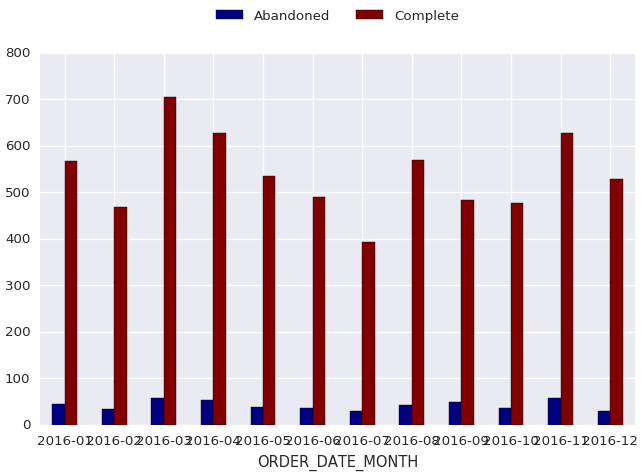

In [39]:
display(abandoned_df)

Now you can drill down to find out more about abandoned transactions:
 - Which age range abandons the most transactions?
 - What method of ordering results in the most abandoned transactions?
 - Do frequent or infrequent customers abandon more transactions?

Create a DataFrame with only abandoned transactions (or whichever type of transactions that the `transaction_type` variable specifies):

In [40]:
# create new data set comprising of all <transaction_type> sales transactions
tx_type_sales_df = sales_df.filter("T_TYPE = '" + transaction_type + "'")
# test data set contains synthetic outliers. remove them
tx_type_sales_df = tx_type_sales_df.filter("ORDER_VALUE < 9999999")

Look at the monthly value of abandoned transactions by gender.

Run the next cell and configure the graph:
1. Choose **Bar Chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `ORDER_VALUE` in the **Values** box.
4. Set the Aggregation to **SUM**. 
5. Click **OK**. The chart displays.
6. From the **Cluster By** list, choose **GENDER**.


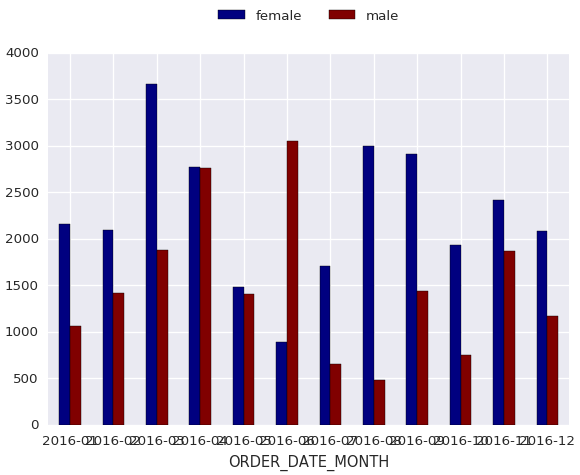

In [ ]:
display(tx_type_sales_df)

Now change the clustering to GENERATION (age), or PURCHASE_STATUS (frequency of purchases), or PURCHASE_TOUCHPOINT (point of sale).

[Back to Table of Contents](#toc)

### Find the value of abandoned transactions
The next thing you need to know about abandoned transactions is how much they were worth.

Identify the average order value for abandoned transactions. 

Run the next cell and configure the graph:
1. Choose **Histogram** as the chart type.
2. Put `ORDER_VALUE` into the **Values** box and click **OK**.

In [42]:
display(tx_type_sales_df)

The majority of analyzed transactions had a value of $50 or less.

[Back to Table of Contents](#toc)

### Analyze product categories for abandoned transactions
Identify the product category for each month that were most often included abandoned transactions.
 
Create a DataFrame with the sum of the items in each category:

In [43]:
exprs = {x: "sum" for x in category_columns}
item_count_df = tx_type_sales_df.groupBy("ORDER_DATE_MONTH").agg(exprs)

Compare the amount of abandoned orders for fresh vegetables and canned foods.

Run the next cell and configure the graph:
1. Choose **Bar Chart** as the chart type.
2. Put `ORDER_DATE_MONTH` into the **Keys** box
3. Put `sum(Fresh Vegetables` and `sum(Canned Foods)` in the **Values** box.
4. Set the Aggregation to **SUM**. 
5. Click **OK**. The chart displays.
6. From the **Type** list, choose **grouped**.


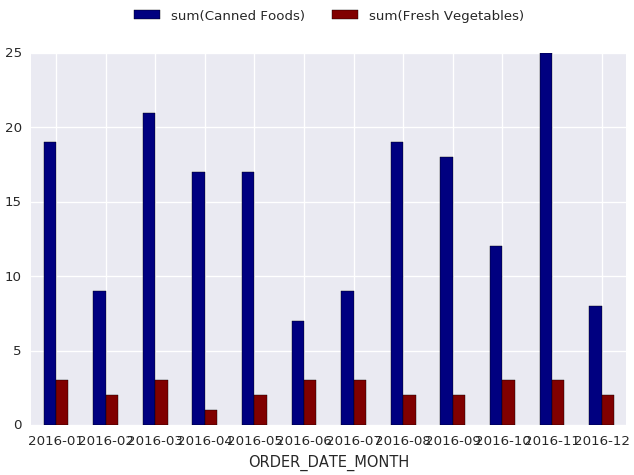

In [ ]:
display(item_count_df)

<a id="summary"></a>
## Summary and next steps

You successfully completed this notebook!  

Check out other notebooks in this series: 
 - Localcart scenario one: Dynamic data analysis and visualization
 - Localcart scenario three: Build a product recommendation engine
 - Localcart scenario four: Build a revenue dashboard using PixieApps

Copyright © 2017, 2018 IBM. This notebook and its source code are released under the terms of the MIT License.